In [23]:
import pandas as pd
import numpy as np
import networkx as nx
import sys
from matplotlib.colors import to_rgba
# adding Folder_2/subfolder to the system path
sys.path.insert(0, '/work/ccnr/glover.co/net_design/NetDesign')
import network_design as nd
import netrd
import matplotlib.pyplot as plt

In [2]:
homo_sapien_co_complex = pd.read_csv('../../data/protein_complex/HomoSapiens_cocomp_hq.txt',index_col=False,delimiter='\t')
homo_sapien_co_complex['pmid:method:quality:type'] = homo_sapien_co_complex['pmid:method:quality:type'].str.split('|')
homo_sapien_co_complex = homo_sapien_co_complex.explode('pmid:method:quality:type')

In [3]:
g = nx.Graph()

In [4]:
for i, row in homo_sapien_co_complex.iterrows():
    g.add_edge(row['Uniprot_A'],row['Uniprot_B'])

In [5]:
complexes = pd.unique(homo_sapien_co_complex['pmid:method:quality:type'])

In [6]:
# Order complexes by size
complex_sizes = [len(homo_sapien_co_complex[homo_sapien_co_complex['pmid:method:quality:type'] == c]) for c in complexes]

In [7]:
complexes = complexes[np.argsort(complex_sizes)]

### Complex 1

In [8]:
## Get complex
cur_complex = homo_sapien_co_complex[homo_sapien_co_complex['pmid:method:quality:type'] == complexes[17000]]
cur_complex

,Uniprot_A,Uniprot_B,Gene_A,Gene_B,pmid:method:quality:type,taxid,high_quality,in_pdb_source
61733,P0CG13,Q8WVB6,CHTF8,CHTF18,12766176:0004:LC:co-complex,9606,True,False
61734,P0CG13,Q9BVC3,CHTF8,DSCC1,12766176:0004:LC:co-complex,9606,True,False
66474,P12004,P40938,PCNA,RFC3,12766176:0004:LC:co-complex,9606,True,True
66523,P12004,Q8WVB6,PCNA,CHTF18,12766176:0004:LC:co-complex,9606,True,True
91194,P35250,Q8WVB6,RFC2,CHTF18,12766176:0004:LC:co-complex,9606,True,True
91196,P35250,Q9BVC3,RFC2,DSCC1,12766176:0004:LC:co-complex,9606,True,False
95160,P40938,Q8WVB6,RFC3,CHTF18,12766176:0004:LC:co-complex,9606,True,True
95163,P40938,Q9BVC3,RFC3,DSCC1,12766176:0004:LC:co-complex,9606,True,False
179082,Q8WVB6,Q9BVC3,CHTF18,DSCC1,12766176:0004:LC:co-complex,9606,True,False


In [9]:
g_complex_0 = nx.Graph()
for i, row in cur_complex.iterrows():
    g_complex_0.add_edge(row['Uniprot_A'],row['Uniprot_B'])
g_complex_0 = nx.convert_node_labels_to_integers(g_complex_0)

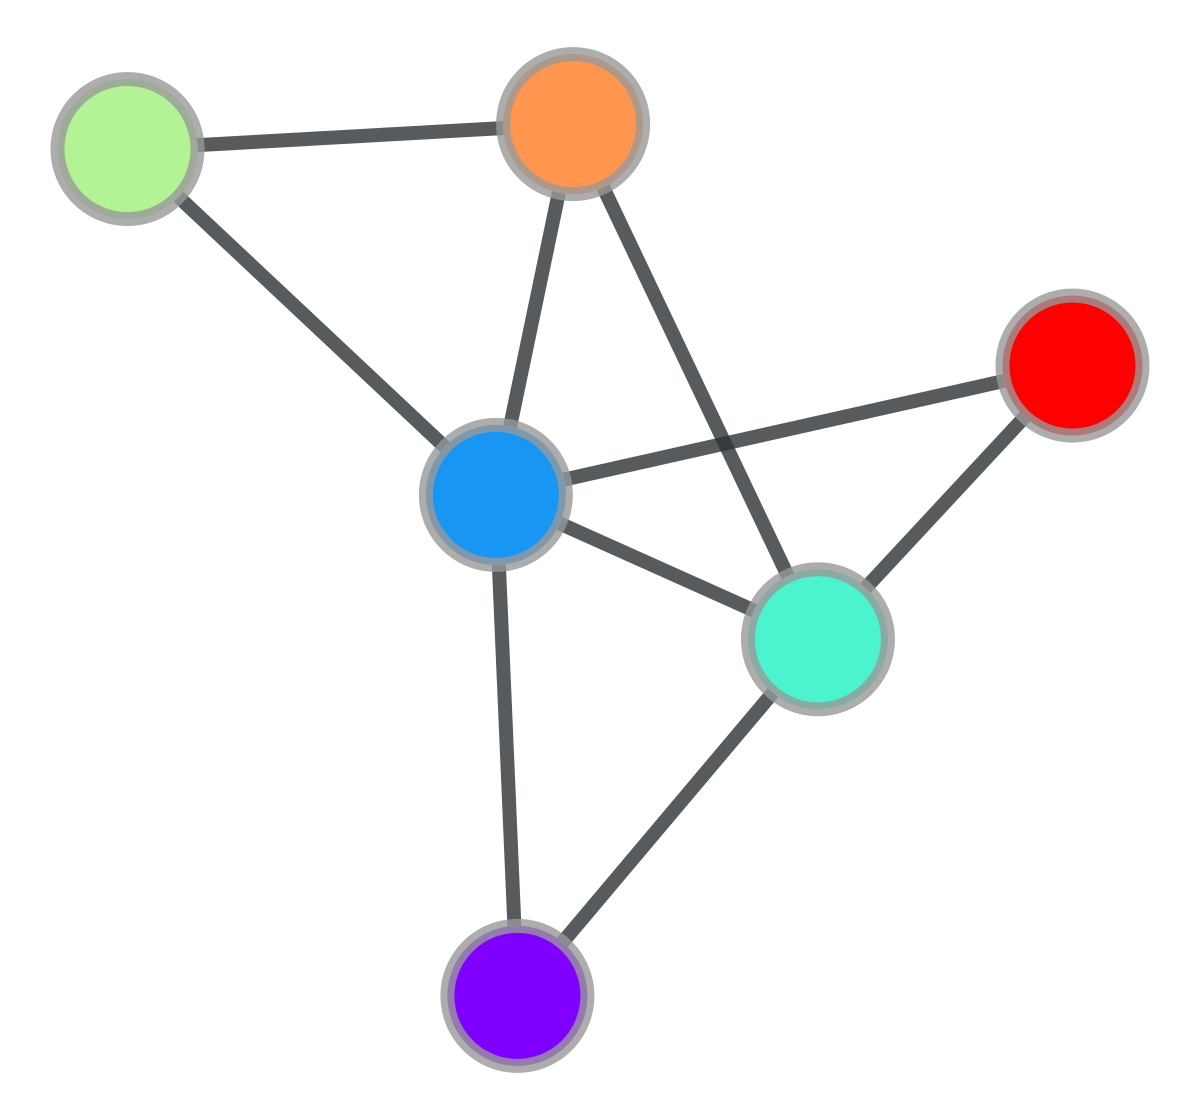

<Figure size 500x500 with 0 Axes>

In [18]:
complex0_model = nd.NetAssembly(X,O,X.sum(axis=0,dtype=int))
complex0_model.g = g_complex_0
complex0_model.draw(with_networkx=False)

In [19]:
node_labels = np.unique(cur_complex['Uniprot_A'].tolist() + cur_complex['Uniprot_B'].tolist())

In [20]:
X = np.eye(len(node_labels),dtype=int)

In [21]:
O = nd.extract_O(g_complex_0,X)

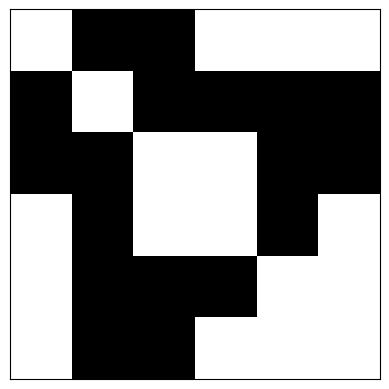

In [25]:
plt.imshow(O,cmap='binary')
plt.xticks([],[])
plt.yticks([],[])
plt.savefig('saccharomyces_cerevisiae_complex_O.pdf')
plt.show()

In [35]:
target_network = g_complex_0
for i in range(19):
    target_network = nx.disjoint_union(g_complex_0,target_network)

In [13]:
new_X = np.tile(X,(20,1))

In [46]:
complex0 = nd.NetAssembly(new_X,O,new_X.sum(axis=0),system_energy=.2)

In [47]:
complex0.run(100000,link_strength=1,component=False)

In [48]:
complex0.draw(with_networkx=False,output='complex0_network_02_1.pdf')

<Figure size 500x500 with 0 Axes>

In [49]:
components = [c for c in nx.connected_components(complex0.g)]
components = sorted(components,key=len,reverse=True)
order = []
for c in components:
    order += list(c)
complex0_A = nx.adjacency_matrix(complex0.g).toarray()
complex0_A = complex0_A[order,:][:,order]
complex0_g = nx.from_numpy_array(complex0_A)

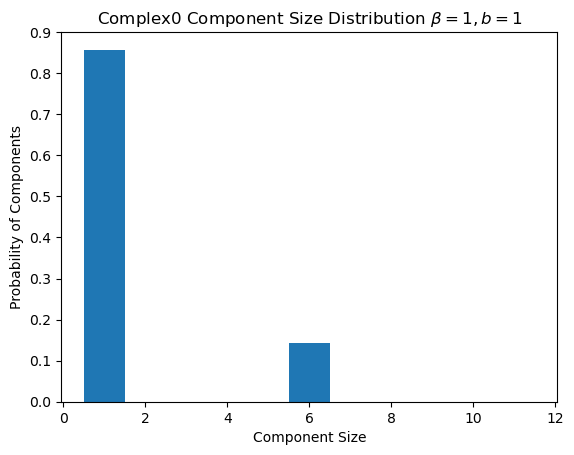

In [50]:
# Get final component distribution
components = [c for c in nx.connected_components(complex0.g)]
component_lengths = [len(c) for c in components]
# Unique component lengths
counts, bins = np.histogram(component_lengths,bins=range(1,13))
plt.bar(bins[:-1],counts/sum(counts),width=1)
plt.xlabel('Component Size')
plt.ylabel('Probability of Components')
plt.title(r'Complex0 Component Size Distribution $\beta=1,b=1$')
plt.savefig('complex0_02_1_component_dist.pdf')
plt.show()

In [38]:
distances = {
    'Jaccard':                 netrd.distance.JaccardDistance(),
    'Hamming':                 netrd.distance.Hamming(),
    'HammingIpsenMikhailov':   netrd.distance.HammingIpsenMikhailov(),
    'Frobenius':               netrd.distance.Frobenius(),
    'PolynomialDissimilarity': netrd.distance.PolynomialDissimilarity(),
    'DegreeDivergence':        netrd.distance.DegreeDivergence(),
    'PortraitDivergence':      netrd.distance.PortraitDivergence(),
    'QuantumJSD':              netrd.distance.QuantumJSD(),
    'CommunicabilityJSD':      netrd.distance.CommunicabilityJSD(),
    'GraphDiffusion':          netrd.distance.GraphDiffusion(),
    # 'ResistancePerturbation':  netrd.distance.ResistancePerturbation(),
    'NetLSD':                  netrd.distance.NetLSD(),
    'IpsenMikhailov':          netrd.distance.IpsenMikhailov(),
    # 'NonBacktrackingSpectral': netrd.distance.NonBacktrackingSpectral(),
    'DistributionalNBD':       netrd.distance.DistributionalNBD(),
    # 'DMeasure':                netrd.distance.DMeasure(),
    'DeltaCon':                netrd.distance.DeltaCon(),
    'NetSimile':               netrd.distance.NetSimile()}

In [51]:
# dictionary to store the outputs
dists = {}

# loop over all the reconstruction techniques
for d_lab, d_i in distances.items():
    dists[d_lab] = d_i.dist(complex0_g,target_network)

In [40]:
reference_g = nx.configuration_model(np.array(target_network.degree())[:,1])
components = [c for c in nx.connected_components(reference_g)]
components = sorted(components,key=len,reverse=True)
# Get the order of the nodes
order = []
for c in components:
    order += list(c)
# Relabel the nodes
reference_A = nx.adjacency_matrix(reference_g).toarray()
reference_A = reference_A[order,:][:,order]
reference_g = nx.from_numpy_array(reference_A)

In [41]:
ref_dists = {}

# loop over all the reconstruction techniques
for d_lab, d_i in distances.items():
    ref_dists[d_lab] = d_i.dist(reference_g,target_network)

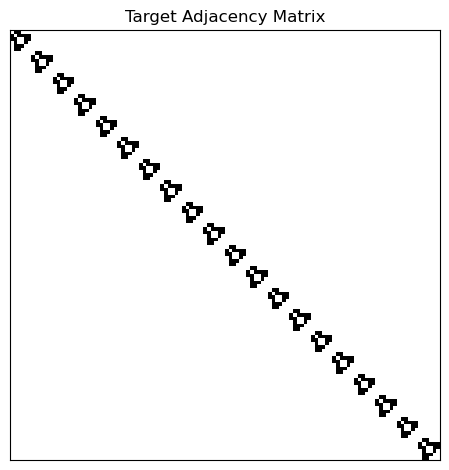

In [42]:
target_A = nx.adjacency_matrix(target_network).toarray()
plt.imshow(target_A,cmap='binary')
plt.xticks([],[])
plt.yticks([],[])
plt.title('Target Adjacency Matrix')
plt.tight_layout()
plt.savefig('complex0_target_adjacency_matrix.pdf')
plt.show()

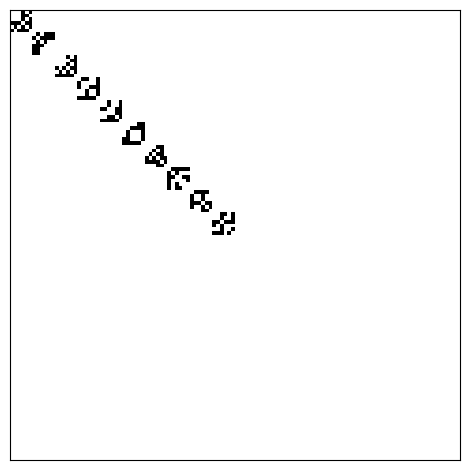

In [52]:
target_A = nx.adjacency_matrix(complex0_g).toarray()
plt.imshow(target_A,cmap='binary')
plt.xticks([],[])
plt.yticks([],[])
# plt.title('Target Adjacency Matrix')
plt.tight_layout()
plt.savefig('complex0_02_1_adjacency_matrix.pdf')
plt.show()

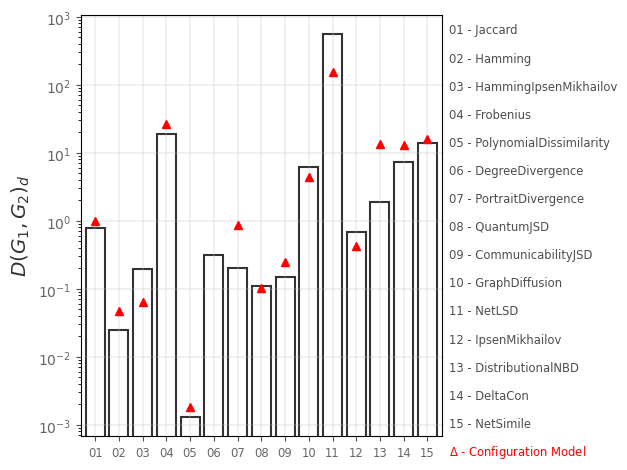

In [53]:
fig, ax = plt.subplots()
ax.bar(x=list(range(len(dists))), height=list(dists.values()), fc='w', ec='.2', lw=1.5)
ax.set_xticks(list(range(len(dists))))
ax.set_xticklabels(["%02i"%(i+1) for i in list(range(len(dists)))],fontsize='small')
ax.set_xlim(-0.6,len(distances)-0.4)
ax.set_yscale('log')
ax.set_ylabel(r'$D(G_1, G_2)_d$', fontsize='x-large', color='.2')
ax.tick_params(labelbottom=True, bottom=True, labelleft=True, left=True, labelcolor='.4', color='.3')
ax.grid(linewidth=1.25,color='.75',alpha=0.25)
for i, title_i in enumerate(list(distances.keys()) + ['Reference']):
    lab_i = "%02i - %s"%(i+1,title_i)
    if i == len(distances):
        lab_i = r"$\Delta$ - Configuration Model"
        ax.text(1.02, 1-(i/len(distances))-0.55/len(distances), lab_i, ha='left', va='center',
               color='r', transform=ax.transAxes, fontsize='small')
    else:
        ax.text(1.02, 1-(i/len(distances))-0.55/len(distances), lab_i, ha='left', va='center',
               color='.3', transform=ax.transAxes, fontsize='small')
ax.plot(np.arange(15),list(ref_dists.values()),'^',color='red',label='CM')
plt.tight_layout()
plt.savefig('complex0_02_1_distance_comparison.pdf')
plt.show()

In [19]:
new_obj = nd.NetAssembly(new_X,O,new_X.sum(axis=0))

In [20]:
new_obj.g = h

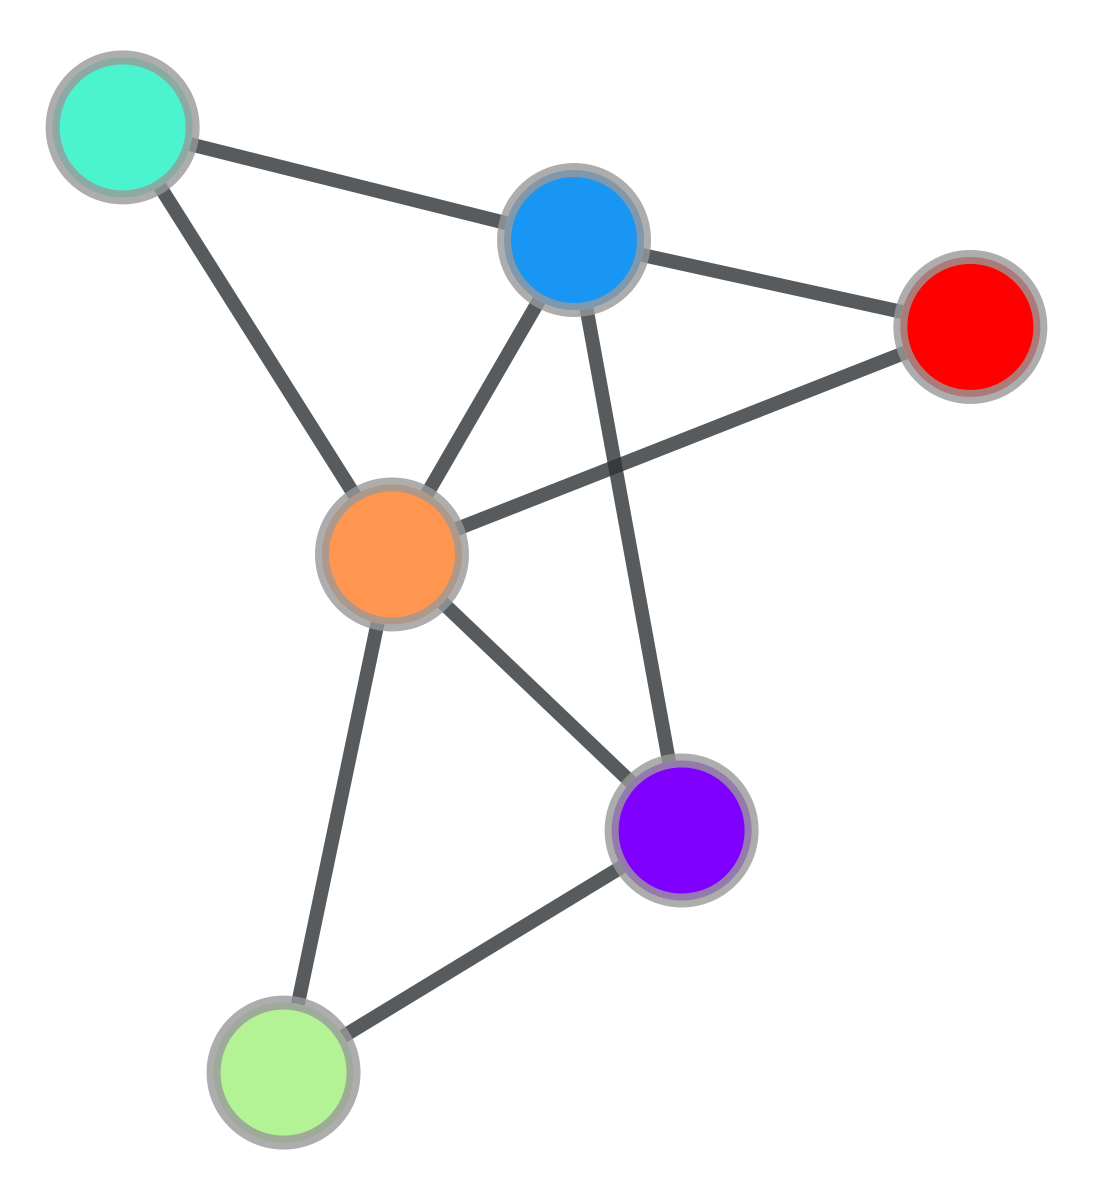

<Figure size 500x500 with 0 Axes>

In [21]:
new_obj.draw(with_networkx=False)

### Complex 2

In [55]:
cur_complex = homo_sapien_co_complex[homo_sapien_co_complex['pmid:method:quality:type'] == complexes[17008]]
cur_complex

,Uniprot_A,Uniprot_B,Gene_A,Gene_B,pmid:method:quality:type,taxid,high_quality,in_pdb_source
62311,P0CG48,Q15796,UBC,SMAD2,19917253:0004:LC:co-complex,9606,True,False
62312,P0CG48,Q15797,UBC,SMAD1,19917253:0004:LC:co-complex,9606,True,False
122892,P84022,Q13485,SMAD3,SMAD4,19917253:0004:LC:co-complex,9606,True,True
122908,P84022,Q96PU5,SMAD3,NEDD4L,19917253:0004:LC:co-complex,9606,True,True
122912,P84022,Q9HAU4,SMAD3,SMURF2,19917253:0004:LC:co-complex,9606,True,False
135693,Q13485,Q15796,SMAD4,SMAD2,19917253:0004:LC:co-complex,9606,True,True
147305,Q15796,Q96PU5,SMAD2,NEDD4L,19917253:0004:LC:co-complex,9606,True,False
147324,Q15797,Q9HAU4,SMAD1,SMURF2,19917253:0004:LC:co-complex,9606,True,False
147325,Q15797,Q9HCE7,SMAD1,SMURF1,19917253:0004:LC:co-complex,9606,True,True


In [56]:
g_complex_0 = nx.Graph()
for i, row in cur_complex.iterrows():
    g_complex_0.add_edge(row['Uniprot_A'],row['Uniprot_B'])
g_complex_0 = nx.convert_node_labels_to_integers(g_complex_0)

In [62]:
complex1_model = nd.NetAssembly(X,O,X.sum(axis=0,dtype=int))
complex1_model.g = g_complex_0
complex1_model.draw(with_networkx=False,output='complex1_target_network.pdf')

<Figure size 500x500 with 0 Axes>

In [57]:
node_labels = np.unique(cur_complex['Uniprot_A'].tolist() + cur_complex['Uniprot_B'].tolist())

In [58]:
X = np.eye(len(node_labels),dtype=int)

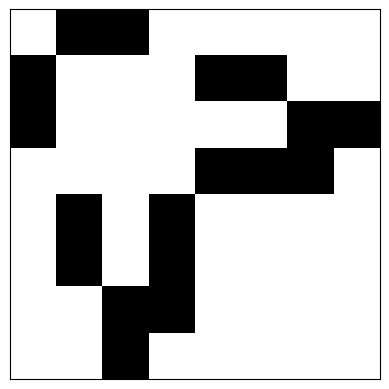

In [63]:
O = nd.extract_O(g_complex_0,X)
plt.imshow(O,cmap='binary')
plt.xticks([],[])
plt.yticks([],[])
plt.savefig('complex1_O.pdf')
plt.show()

In [64]:
new_X = np.tile(X,(20,1))

In [120]:
complex0 = nd.NetAssembly(new_X,O,new_X.sum(axis=0),system_energy=.4)

In [121]:
complex0.run(1000000,link_strength=1,component=False)

In [122]:
complex0.draw(with_networkx=False,output='complex1_02_1_network.pdf')

<Figure size 500x500 with 0 Axes>

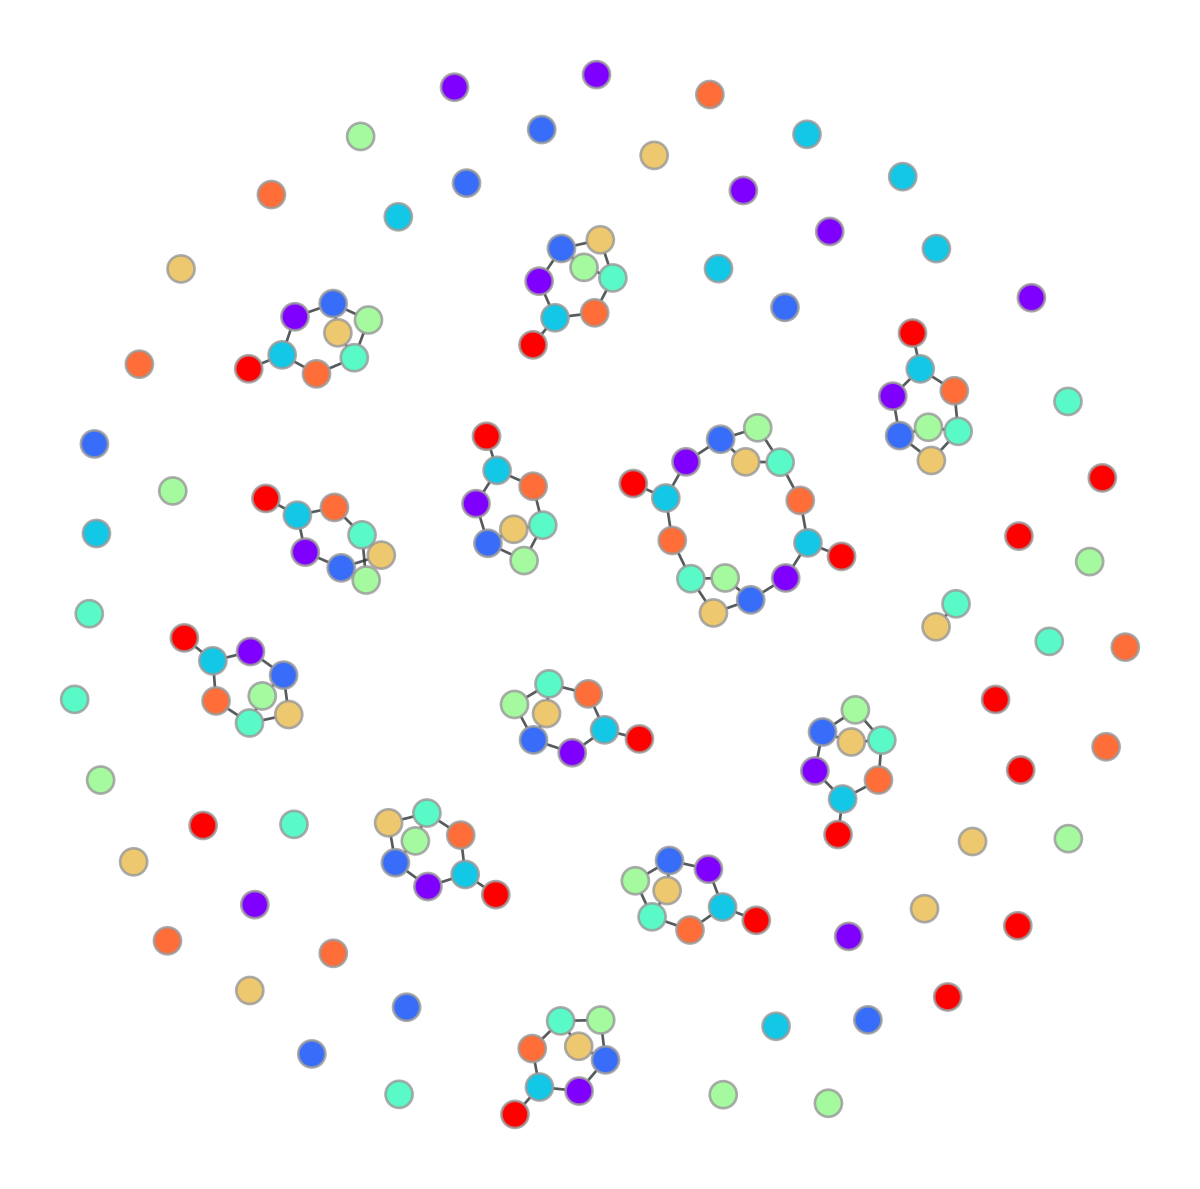

<Figure size 500x500 with 0 Axes>

In [123]:
complex0.draw(with_networkx=False)

In [124]:
target_network = g_complex_0
for i in range(19):
    target_network = nx.disjoint_union(g_complex_0,target_network)

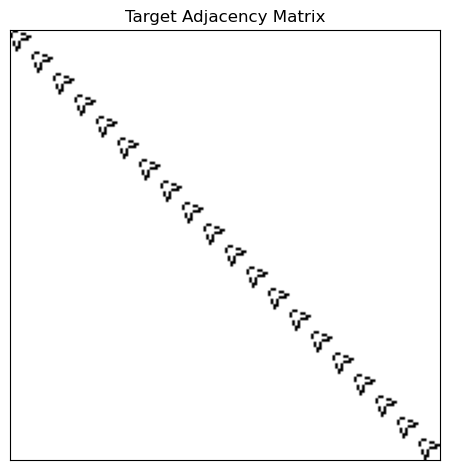

In [125]:
target_A = nx.adjacency_matrix(target_network).toarray()
plt.imshow(target_A,cmap='binary')
plt.xticks([],[])
plt.yticks([],[])
plt.title('Target Adjacency Matrix')
plt.tight_layout()
plt.savefig('complex1_target_adjacency_matrix.pdf')
plt.show()

In [126]:
components = [c for c in nx.connected_components(complex0.g)]
components = sorted(components,key=len,reverse=True)
order = []
for c in components:
    order += list(c)
complex0_A = nx.adjacency_matrix(complex0.g).toarray()
complex0_A = complex0_A[order,:][:,order]
complex0_g = nx.from_numpy_array(complex0_A)

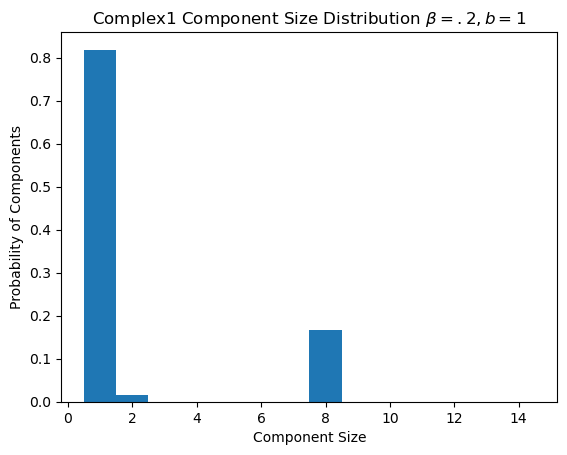

In [127]:
# Get final component distribution
components = [c for c in nx.connected_components(complex0.g)]
component_lengths = [len(c) for c in components]
# Unique component lengths
counts, bins = np.histogram(component_lengths,bins=range(1,max(component_lengths)))
plt.bar(bins[:-1],counts/sum(counts),width=1)
plt.xlabel('Component Size')
plt.ylabel('Probability of Components')
plt.title(r'Complex1 Component Size Distribution $\beta=.2,b=1$')
plt.savefig('complex1_02_1_component_dist.pdf')
plt.show()

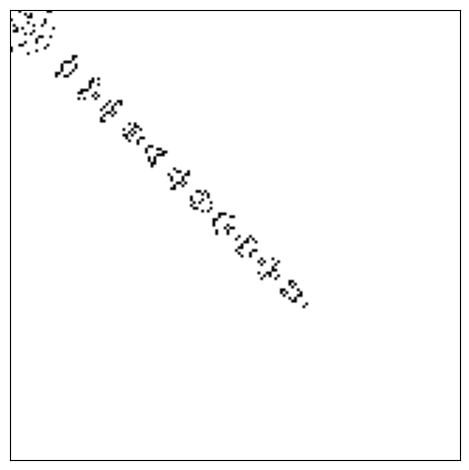

In [128]:
target_A = nx.adjacency_matrix(complex0_g).toarray()
plt.imshow(target_A,cmap='binary')
plt.xticks([],[])
plt.yticks([],[])
# plt.title('Target Adjacency Matrix')
plt.tight_layout()
plt.savefig('complex1_02_1_adjacency_matrix.pdf')
plt.show()

In [129]:
reference_g = nx.configuration_model(np.array(target_network.degree())[:,1])
components = [c for c in nx.connected_components(reference_g)]
components = sorted(components,key=len,reverse=True)
# Get the order of the nodes
order = []
for c in components:
    order += list(c)
# Relabel the nodes
reference_A = nx.adjacency_matrix(reference_g).toarray()
reference_A = reference_A[order,:][:,order]
reference_g = nx.from_numpy_array(reference_A)

In [130]:
ref_dists = {}

# loop over all the reconstruction techniques
for d_lab, d_i in distances.items():
    ref_dists[d_lab] = d_i.dist(reference_g,target_network)

/home/glover.co/miniconda3/envs/gt/lib/python3.12/site-packages/netrd/utilities/graph.py:118: RuntimeWarning: Coercing weighted graph to unweighted.
  warnings.warn("Coercing weighted graph to unweighted.", RuntimeWarning)


In [131]:
# dictionary to store the outputs
dists = {}

# loop over all the reconstruction techniques
for d_lab, d_i in distances.items():
    dists[d_lab] = d_i.dist(complex0_g,target_network)

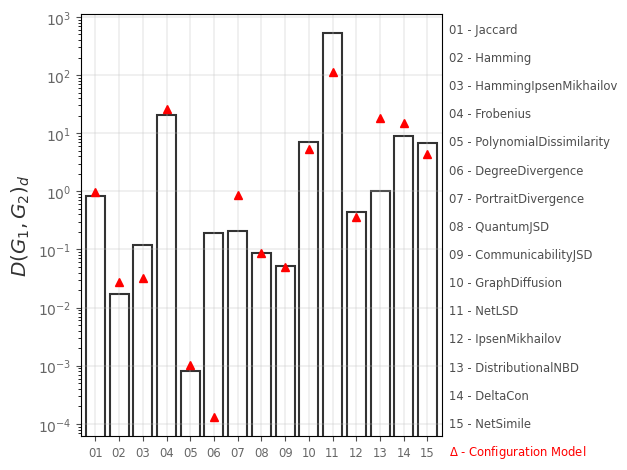

In [132]:
fig, ax = plt.subplots()
ax.bar(x=list(range(len(dists))), height=list(dists.values()), fc='w', ec='.2', lw=1.5)
ax.set_xticks(list(range(len(dists))))
ax.set_xticklabels(["%02i"%(i+1) for i in list(range(len(dists)))],fontsize='small')
ax.set_xlim(-0.6,len(distances)-0.4)
ax.set_yscale('log')
ax.set_ylabel(r'$D(G_1, G_2)_d$', fontsize='x-large', color='.2')
ax.tick_params(labelbottom=True, bottom=True, labelleft=True, left=True, labelcolor='.4', color='.3')
ax.grid(linewidth=1.25,color='.75',alpha=0.25)
for i, title_i in enumerate(list(distances.keys()) + ['Reference']):
    lab_i = "%02i - %s"%(i+1,title_i)
    if i == len(distances):
        lab_i = r"$\Delta$ - Configuration Model"
        ax.text(1.02, 1-(i/len(distances))-0.55/len(distances), lab_i, ha='left', va='center',
               color='r', transform=ax.transAxes, fontsize='small')
    else:
        ax.text(1.02, 1-(i/len(distances))-0.55/len(distances), lab_i, ha='left', va='center',
               color='.3', transform=ax.transAxes, fontsize='small')
ax.plot(np.arange(15),list(ref_dists.values()),'^',color='red',label='CM')
plt.tight_layout()
plt.savefig('complex1_02_1_distance_comparison.pdf')
plt.show()

In [96]:
cur_complex = homo_sapien_co_complex[homo_sapien_co_complex['pmid:method:quality:type'] == complexes[17708]]

In [97]:
g_complex_0 = nx.Graph()
for i, row in cur_complex.iterrows():
    g_complex_0.add_edge(row['Uniprot_A'],row['Uniprot_B'])
g_complex_0 = nx.convert_node_labels_to_integers(g_complex_0)

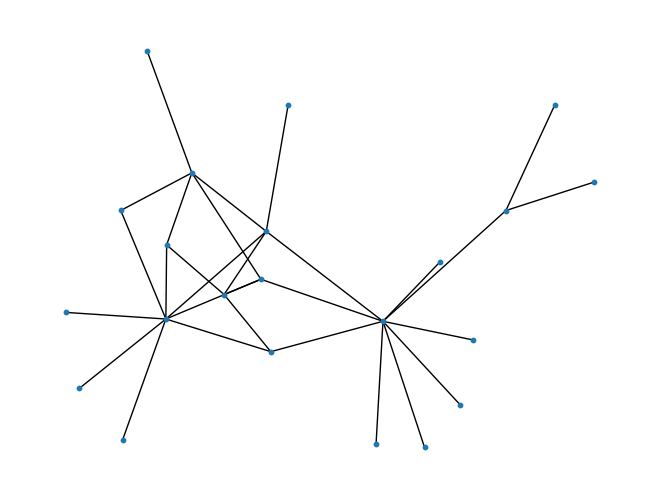

In [98]:
nx.draw(g_complex_0,node_size=10)

In [99]:
node_labels = np.unique(cur_complex['Uniprot_A'].tolist() + cur_complex['Uniprot_B'].tolist())

In [100]:
X = np.eye(len(node_labels),dtype=int)

In [101]:
O = nd.extract_O(g_complex_0,X)

In [102]:
new_X = np.tile(X,(10,1))

In [140]:
complex0 = nd.NetAssembly(new_X,O,new_X.sum(axis=0),system_energy=1)

In [141]:
complex0.run(100000,link_strength=.2,component=False)

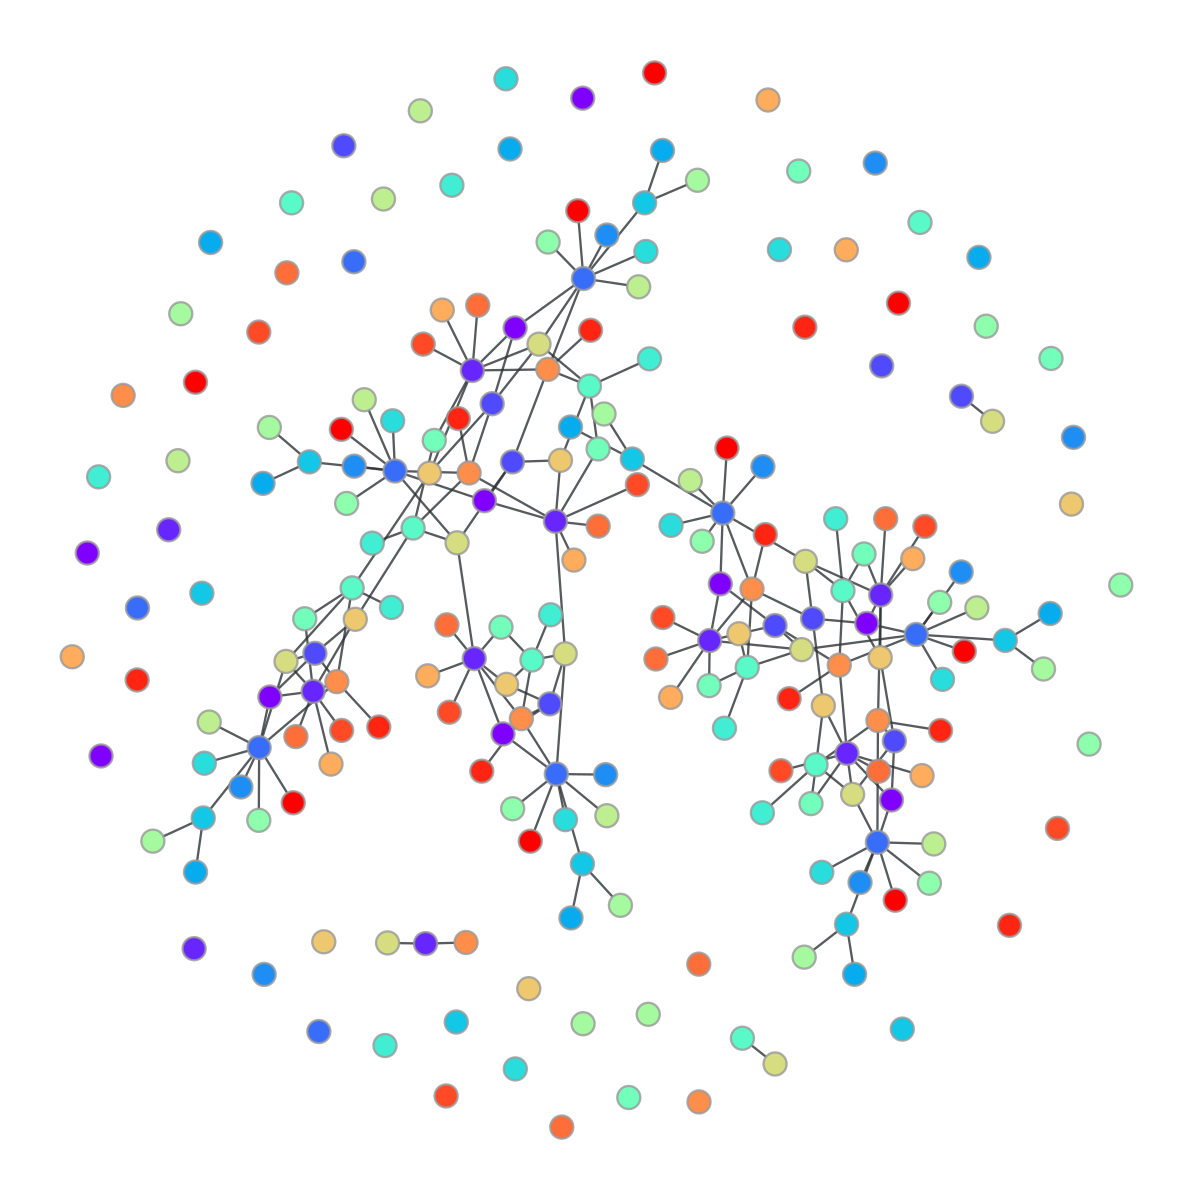

<Figure size 500x500 with 0 Axes>

In [139]:
complex0.draw(with_networkx=False)

In [107]:
h = nx.subgraph(complex0.g,sorted(list(nx.connected_components(complex0.g)),key=len,reverse=True)[2])

In [108]:
new_obj = nd.NetAssembly(new_X,O,new_X.sum(axis=0))

In [109]:
new_obj.g = h

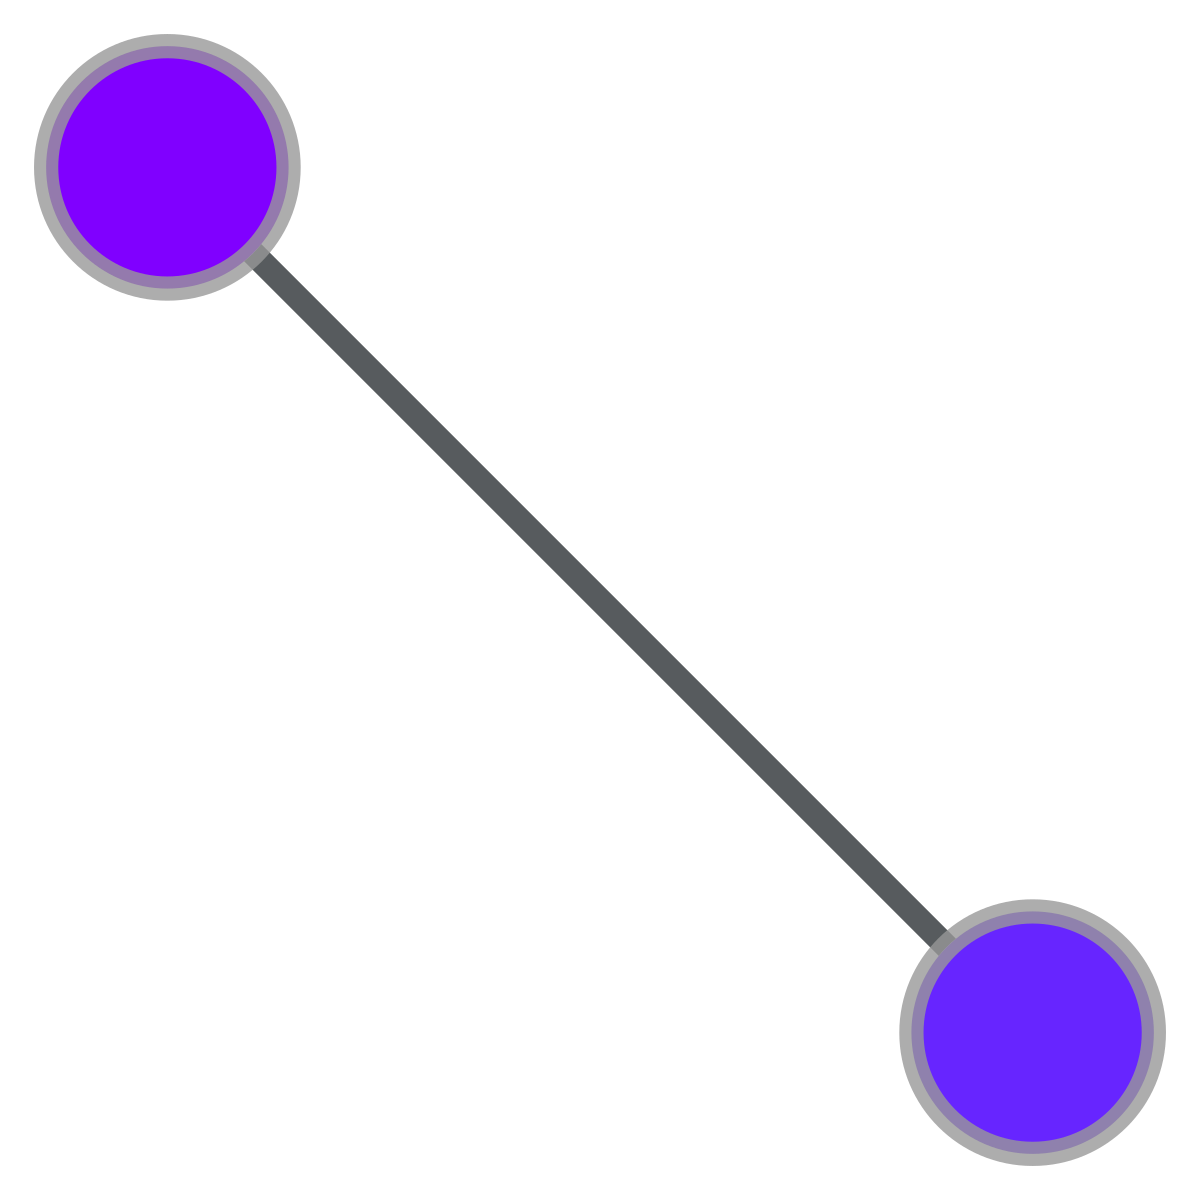

<Figure size 500x500 with 0 Axes>

In [110]:
new_obj.draw(with_networkx=False)